# Proyecto G5 - Recomendaciones de Restaurantes



*   Grace Espinoza
*   Allison Holguin
*   Ken Luzuriaga






#**Explicación del proyecto**

**Objetivo general:**

Desarrollar un sistema de recomendación de restaurantes eficiente y preciso.

**Objetivos específicos:**

Realizar un análisis exploratorio del dataset de reseñas utilizando técnicas de análisis de datos con Python.

Implementar un modelo de recomendación utilizando PySpark para procesar grandes conjuntos de datos.

Evaluar y perfeccionar el modelo para garantizar recomendaciones precisas y personalizadas.

Desarrollar una interfaz amigable para que los usuarios interactúen con el sistema de recomendación


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9f4b847a171823ab03824480d6b8f360980da40b716d7dd2db3e9ab02475533f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# **Carga de datos**


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np # linear algebra
from pyspark.sql.functions import avg
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc
from pyspark.sql.window import Window
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("ProyectoRecetas").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# carga de datos
reviews_format = pd.read_csv("/content/drive/MyDrive/datos/Restaurant reviews.csv") # Usado para solventar el error del delimitado por ","


In [5]:
# Convertimos el dataframe de pandas a Uno de Spark
df=spark.createDataFrame(reviews_format)
df.show(10)

+---------------+--------------------+--------------------+------+--------------------+---------------+--------+
|     Restaurant|            Reviewer|              Review|Rating|            Metadata|           Time|Pictures|
+---------------+--------------------+--------------------+------+--------------------+---------------+--------+
|Beyond Flavours|   Rusha Chakraborty|The ambience was ...|     5|1 Review , 2 Foll...|5/25/2019 15:54|       0|
|Beyond Flavours|Anusha Tirumalaneedi|Ambience is too g...|     5|3 Reviews , 2 Fol...|5/25/2019 14:20|       0|
|Beyond Flavours|     Ashok Shekhawat|A must try.. grea...|     5|2 Reviews , 3 Fol...|5/24/2019 22:54|       0|
|Beyond Flavours|      Swapnil Sarkar|Soumen das and Ar...|     5|1 Review , 1 Foll...|5/24/2019 22:11|       0|
|Beyond Flavours|              Dileep|Food is good.we o...|     5|3 Reviews , 2 Fol...|5/24/2019 21:37|       0|
|Beyond Flavours|       Nagabhavani K|Ambiance is good,...|     5|            1 Review|5/24/2019

In [6]:
# Mostrar el esquema actual del DataFrame
df.printSchema()

root
 |-- Restaurant: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Metadata: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Pictures: long (nullable = true)



# **Limpieza de datos**


In [7]:
# Tratar valores nulos
df = df.dropna()


In [8]:
#Eliminar duplicados
df = df.dropDuplicates()
df.show(6)

+--------------------+-------------+--------------------+------+--------------------+---------------+--------+
|          Restaurant|     Reviewer|              Review|Rating|            Metadata|           Time|Pictures|
+--------------------+-------------+--------------------+------+--------------------+---------------+--------+
|            Flechazo| Ketan SPatil|Good food\nNice e...|     5|            1 Review|5/11/2019 22:40|       0|
|Over The Moon Bre...|    Jayaram K|Great finger food...|     5|24 Reviews , 15 F...| 5/4/2019 23:21|       0|
|         Hyper Local|Areeba Fatima|Been here for my ...|     5|6 Reviews , 4 Fol...|5/15/2019 18:29|       0|
|Sardarji's Chaats...| Aditi Saxena|        great good!!|     5|3 Reviews , 33 Fo...|9/14/2018 21:03|       0|
|     Barbeque Nation|Mario Fonseca|Been to the place...|     4|45 Reviews , 82 F...|2/21/2019 21:27|       0|
|     Barbeque Nation|      Harry N|Excellent place.\...|     4|28 Reviews , 9 Fo...|11/2/2018 12:18|       0|
+

In [9]:
df.count()

9964

In [10]:
# Eliminar las filas donde la columna "Rating" es igual a "Like" y "Nan"
df = df.filter(col("Rating") != "Like")
df = df.filter(col("Rating") != "NaN")
# Mostrar el recuento de valores en la columna "Rating"
df.groupBy("Rating").count().show()

+------+-----+
|Rating|count|
+------+-----+
|     3| 1193|
|   4.5|   69|
|   2.5|   19|
|     5| 3832|
|   3.5|   47|
|   1.5|    9|
|     1| 1735|
|     4| 2373|
|     2|  684|
+------+-----+



Seteando IDs a cada Restaurante y Reviewer único


In [11]:
windowSpec = Window().orderBy("Restaurant")
df = df.withColumn("restaurant_id", F.dense_rank().over(windowSpec))
windowSpec = Window().orderBy("Reviewer")
df = df.withColumn("reviewer_id", F.dense_rank().over(windowSpec))


In [12]:
# Comprobando si los ids son los mismos por cada restaurante
search = df.filter(df.Restaurant == "The Fisherman's Wharf")
search.show(3)

+--------------------+------------------+--------------------+------+--------------------+---------------+--------+-------------+-----------+
|          Restaurant|          Reviewer|              Review|Rating|            Metadata|           Time|Pictures|restaurant_id|reviewer_id|
+--------------------+------------------+--------------------+------+--------------------+---------------+--------+-------------+-----------+
|The Fisherman's W...|   Aashima Bhootna|Visited this plac...|     3|20 Reviews , 8 Fo...|3/10/2019 20:57|       7|           85|         68|
|The Fisherman's W...|     Abhijit Aachi|I love sea food a...|     5|           9 Reviews| 4/14/2019 1:38|       0|           85|        110|
|The Fisherman's W...|Abhimanyu Padmaraj|This place is a p...|     5|81 Reviews , 248 ...|3/24/2019 15:45|       8|           85|        126|
+--------------------+------------------+--------------------+------+--------------------+---------------+--------+-------------+-----------+
only s

In [13]:
from pyspark.sql.functions import col,explode
df= df.\
          withColumn('restaurant_id',col('restaurant_id').cast('integer')).\
          withColumn('reviewer_id',col('reviewer_id').cast('integer')).\
          withColumn('Rating',col('Rating').cast('float'))

In [14]:
df_pandas = df.toPandas()

# **Visualizaciones con análisis**


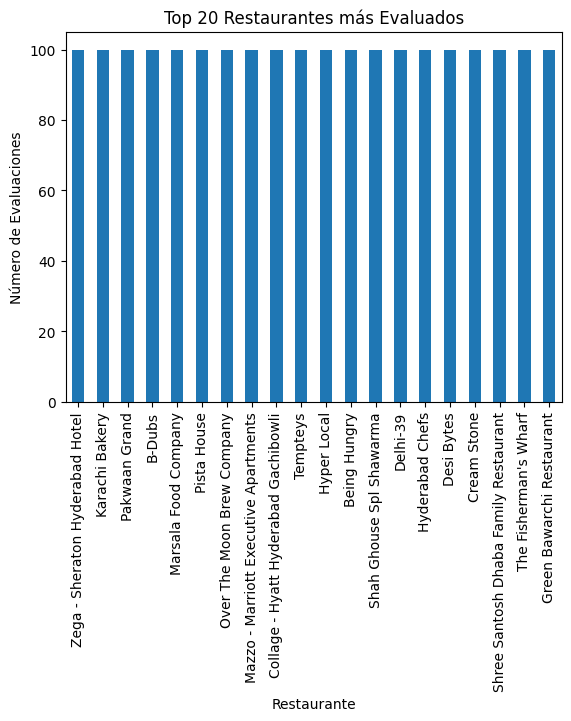

In [15]:
import matplotlib.pyplot as plt

# Graficar la distribución de la columna "Restaurant"
df_pandas['Restaurant'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Restaurantes más Evaluados')
plt.xlabel('Restaurante')
plt.ylabel('Número de Evaluaciones')
plt.show()

**ANÁLISIS**


El gráfico muestra que el restaurante Flechazo tiene la mayor cantidad de evaluaciones, con un total de 100. Le sigue Squeeze @ The Lime con 80 evaluaciones, y Eat India Company con 60 evaluaciones. Los restaurantes restantes tienen entre 40 y 20 evaluaciones.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
!pip install matplotlib seaborn pandas

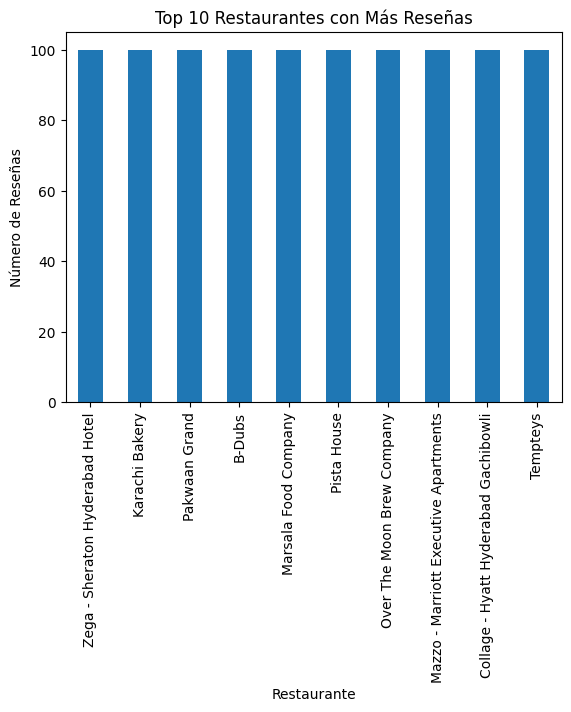

In [18]:
# Visualización de los 10 restaurantes con más reseñas
top_restaurants = df_pandas['Restaurant'].value_counts().nlargest(10)
top_restaurants.plot(kind='bar')
plt.title('Top 10 Restaurantes con Más Reseñas')
plt.xlabel('Restaurante')
plt.ylabel('Número de Reseñas')
plt.show()

# **ANÁLISIS**
El gráfico muestra una distribución concentrada en la puntuacion de 5, la maxima.
Ademas, hay pocos restaurantes que tienen puntuaciones no enteros. Los reviewers son decisivos al rankear y no colocan decimales en la mayoria


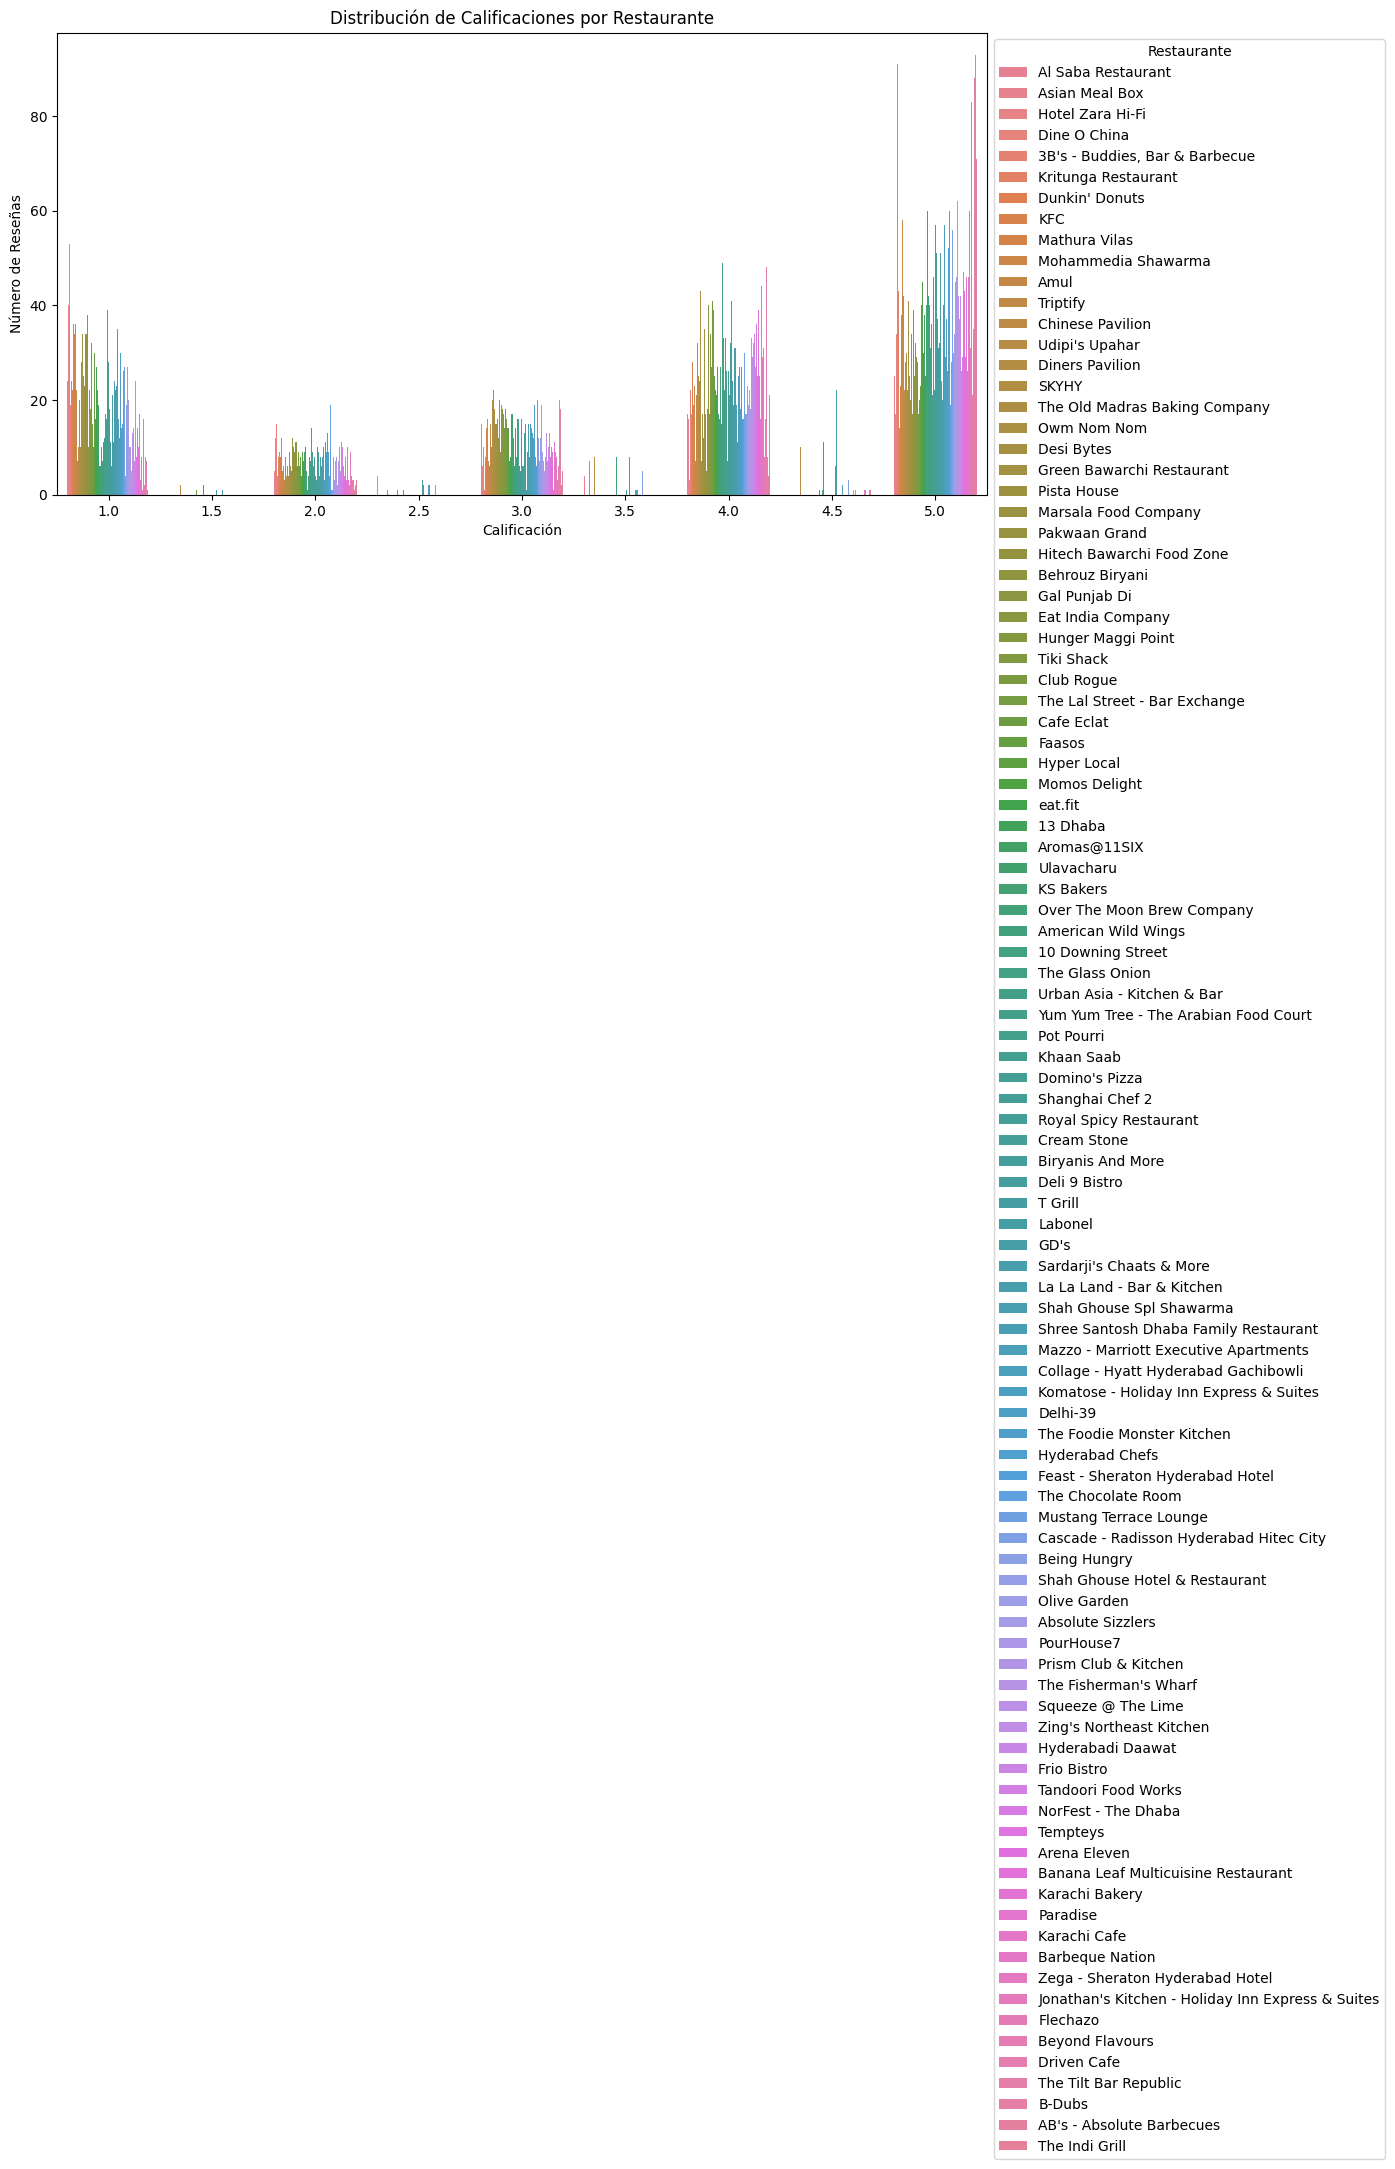

In [19]:
# Visualización de la distribución de las calificaciones con descripción
plt.figure(figsize=(12, 6))
sns.countplot(x='Rating', data=df_pandas, hue='Restaurant')
plt.title('Distribución de Calificaciones por Restaurante')
plt.xlabel('Calificación')
plt.ylabel('Número de Reseñas')
plt.legend(title='Restaurante', bbox_to_anchor=(1, 1))
plt.show()

# **ANÁLISIS**
** Flechazo tiene el mayor número de calificaciones, con alrededor de 80.

**Sardarji's Chaats & More, Barbeque Nation y Absalute Sizzlers lo siguen de cerca, con alrededor de 60 calificaciones cada uno.

**La mayoría de los restaurantes tienen entre 20 y 40 calificaciones.

**Unos pocos restaurantes tienen un número de calificaciones significativamente menor, con Shanghai Chef 2 y Mathura Vilas recibiendo solo alrededor de 10 calificaciones cada uno.

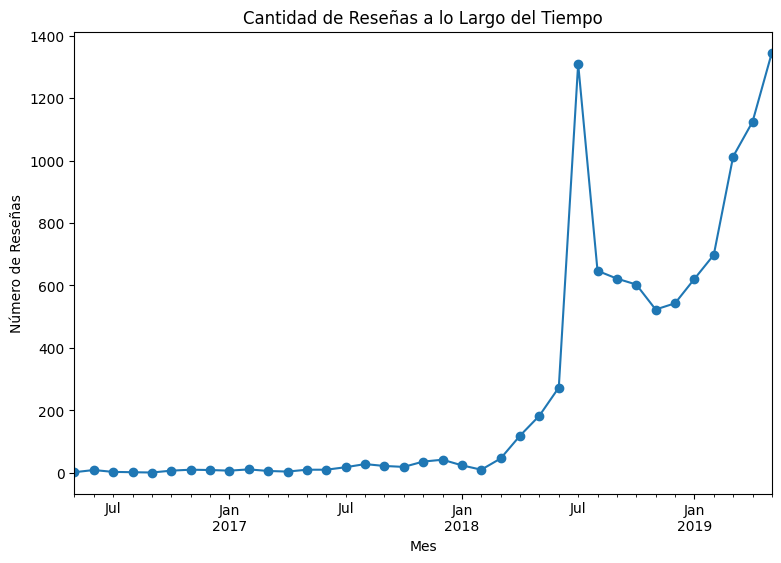

In [20]:
# Visualización de la cantidad de reseñas a lo largo del tiempo
df_pandas['Time'] = pd.to_datetime(df_pandas['Time'])
df_pandas['YearMonth'] = df_pandas['Time'].dt.to_period('M')
reviews_over_time = df_pandas.groupby('YearMonth').size()
plt.figure(figsize=(9, 6))
reviews_over_time.plot(kind='line', marker='o')
plt.title('Cantidad de Reseñas a lo Largo del Tiempo')
plt.xlabel('Mes')
plt.ylabel('Número de Reseñas')
plt.show()

### Top 10 Reviewers
Definimos que usuarios son los mas activos. Los que tienen mas numero de reviews y cual es su promedio de rating al valorar los restaurantes

In [21]:

# Agrupa y cuenta las revisiones por revisor
top_reviewer = df.groupBy("Reviewer").agg(count("Reviewer").alias("Review Count"))
# Ordena los resultados en orden descendente y obtén los 10 mejores
windowSpec = Window.orderBy(desc("Review Count"))
top_reviewer = top_reviewer.withColumn("Rank", F.row_number().over(windowSpec))
top_reviewer = top_reviewer.filter("Rank <= 10").drop("Rank")

print("----------Top 10 de usuarios con más revisiones ------------")
top_reviewer.show()

----------Top 10 de usuarios con más revisiones ------------
+--------------------+------------+
|            Reviewer|Review Count|
+--------------------+------------+
|         Parijat Ray|          13|
|              Ankita|          13|
|               Kiran|          12|
|        Vedant Killa|          11|
|           Jay Mehta|          11|
|             Sravani|          10|
|Manojkumar D Namb...|          10|
|Age Of Foodies (S...|          10|
|          Siva Kumar|          10|
|            Priyanka|          10|
+--------------------+------------+



In [22]:
review_ratings = df.groupBy("Reviewer").agg(avg("Rating").alias("Average Ratings"))
total_users = df.select("Reviewer").distinct().count()

average_rating = review_ratings.select(avg("Average Ratings")).first()[0]
print("Un total de {} usuarios han subido un review con un promedio de ratinf de -> {}".format(total_users, round(average_rating, 4)))

# Realiza la fusión con el DataFrame anterior
review_ratings = review_ratings.join(top_reviewer, on="Reviewer", how="inner")

# Ordena y obtén los 10 mejores revisores
windowSpec = Window.orderBy(desc("Review Count"))
top_reviewers = review_ratings.withColumn("Rank", F.row_number().over(windowSpec))
top_reviewers = top_reviewers.filter("Rank <= 10").drop("Rank")
top_reviewers.show()

Un total de 7446 usuarios han subido un review con un promedio de ratinf de -> 3.5789
+--------------------+------------------+------------+
|            Reviewer|   Average Ratings|Review Count|
+--------------------+------------------+------------+
|         Parijat Ray|3.1923076923076925|          13|
|              Ankita| 3.923076923076923|          13|
|               Kiran|               4.5|          12|
|        Vedant Killa|               4.0|          11|
|           Jay Mehta| 3.727272727272727|          11|
|             Sravani|               4.0|          10|
|Manojkumar D Namb...|               3.7|          10|
|Age Of Foodies (S...|               3.5|          10|
|          Siva Kumar|               3.6|          10|
|            Priyanka|               2.6|          10|
+--------------------+------------------+------------+



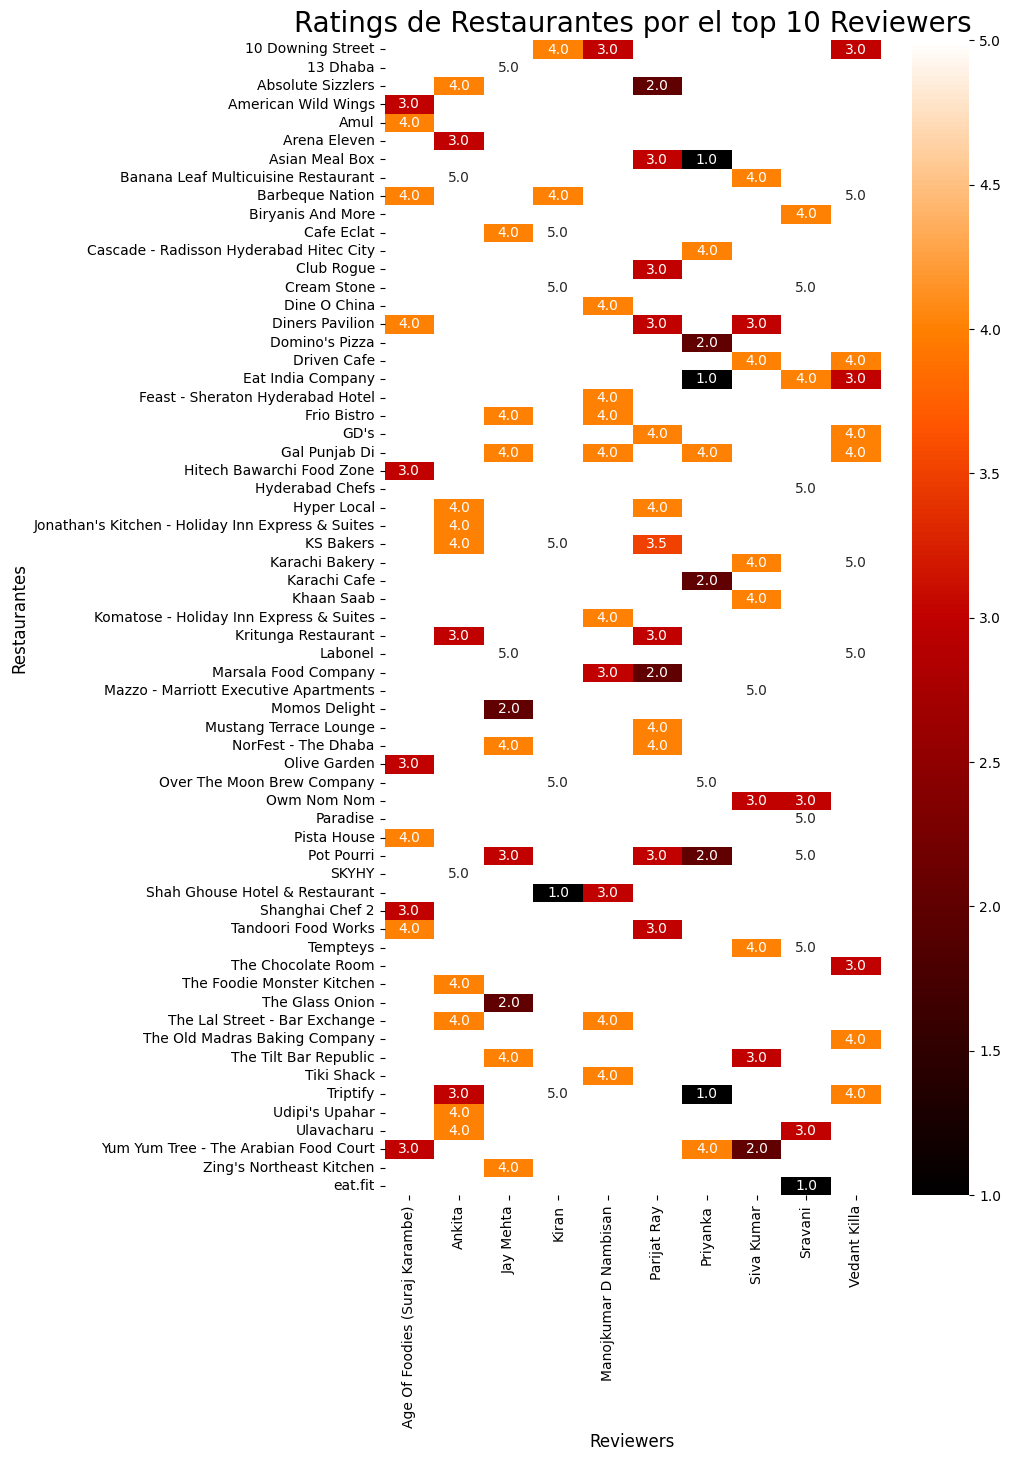

In [23]:
# Realiza la fusión de DataFrames
top_reviews = top_reviewers.join(df, on=["Reviewer", "Reviewer"], how="inner")
# Calcula las calificaciones promedio por revisor y restaurante
top_reviews_avg = top_reviews.groupBy("Reviewer", "Restaurant").agg(avg("Rating").alias("Average Ratings"))
# Convierte el resultado a pandas para el gráfico de mapa de calor
top_reviews_pd = top_reviews_avg.toPandas().pivot(index="Restaurant", columns="Reviewer", values="Average Ratings")

# Crea el gráfico de mapa de calor
plt.figure(figsize=(8, 15))
sns.heatmap(top_reviews_pd, annot=True, fmt=".1f", cmap="gist_heat")
plt.xlabel("Reviewers", size=12)
plt.ylabel("Restaurantes", size=12)
plt.title("Ratings de Restaurantes por el top 10 Reviewers", size=20)

# Muestra el gráfico
plt.show()

Text(0.5, 1.0, 'Promedio de rating de los restaurante por año')

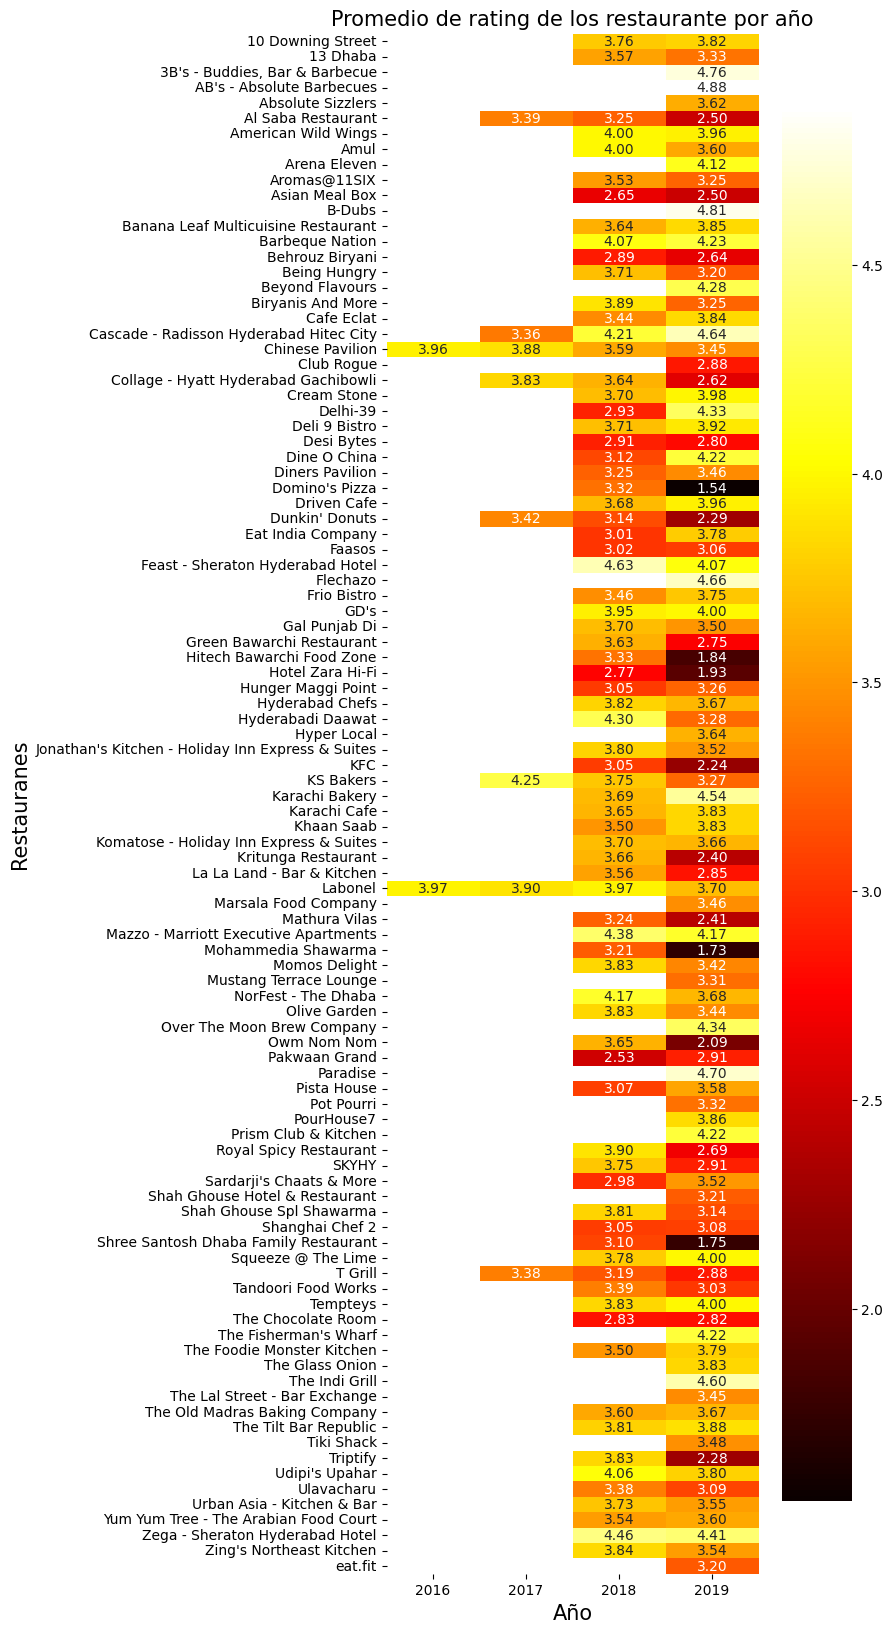

In [24]:
df_pandas['Year'] = pd.DatetimeIndex(df_pandas['Time']).year
rest_time_rev=df_pandas.groupby(['Restaurant','Year']).apply(lambda x:np.average(x['Rating'])).reset_index(name='Average Overall Score')
heatmap_df=pd.pivot(rest_time_rev,values='Average Overall Score',index='Restaurant',columns='Year')
plt.figure(figsize=(6,20))
sns.heatmap(heatmap_df,annot=True,fmt='.2f',cmap='hot')
plt.xlabel('Año',size=15)
plt.ylabel('Restauranes',size=15)
plt.title('Promedio de rating de los restaurante por año',size=15)


In [25]:
pip install wordcloud


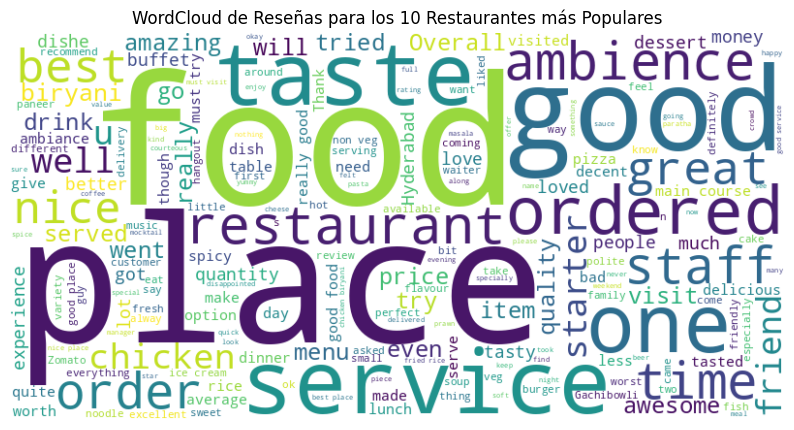

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suponiendo que tienes una columna "Review" en tu DataFrame original (df_pandas)
reviews_text = " ".join(df_pandas['Review'])

# Configura el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(reviews_text)

# Crea el gráfico de WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de Reseñas para los 10 Restaurantes más Populares")
plt.show()



**INTERPRETE**

Los usuarios que mas reseñas postean, lo empezaron hacer desde 2018 a 2019 y en promedio todos los restaurantes tiene un rating de 3.57

In [27]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# **Pre-procesamiento**


In [28]:
from pyspark.sql.functions import col,explode
validation= df.\
          withColumn('restaurant_id',col('restaurant_id').cast('integer')).\
          withColumn('reviewer_id',col('reviewer_id').cast('integer')).\
          withColumn('Rating',col('Rating').cast('float')).\
          drop('Restaurant').drop('Reviewer').drop('Review').drop('Metadata').drop('Time').drop('Pictures')

In [29]:
validation.show(5)


+------+-------------+-----------+
|Rating|restaurant_id|reviewer_id|
+------+-------------+-----------+
|   5.0|           98|          1|
|   5.0|          100|          2|
|   4.0|           74|          3|
|   2.0|           95|          4|
|   5.0|           21|          5|
+------+-------------+-----------+
only showing top 5 rows



In [30]:
num_ratings = validation.select('Rating').count()

num_restau = validation.select('restaurant_id').distinct().count()
num_reviewer = validation.select('reviewer_id').distinct().count()

sparsity = (1.0 - (num_ratings*1.0) / (num_restau*num_reviewer)) * 100
print('Sparsity is ', '%.2f ' % sparsity, '% vacíos', ' para ', num_restau, ' restaurantes y ', num_reviewer, ' usuarios')

Sparsity is  98.66  % vacíos  para  100  restaurantes y  7446  usuarios


In [31]:
user_ratings = validation.groupBy("reviewer_id").count().orderBy('count',ascending=False)
user_ratings.show(5)

+-----------+-----+
|reviewer_id|count|
+-----------+-----+
|        656|   13|
|       3859|   13|
|       2655|   12|
|       2314|   11|
|       7014|   11|
+-----------+-----+
only showing top 5 rows



In [32]:
restaurant_ratings = df.groupBy("restaurant_id").count().orderBy('count',ascending=True)
restaurant_ratings.show(5)

+-------------+-----+
|restaurant_id|count|
+-------------+-----+
|            7|   77|
|            9|   85|
|           90|   99|
|            1|  100|
|            2|  100|
+-------------+-----+
only showing top 5 rows



In [33]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
als = ALS(userCol="reviewer_id", itemCol="restaurant_id", ratingCol="Rating",
          nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")
type(als)

pyspark.ml.recommendation.ALS

In [34]:
param_grid = ParamGridBuilder() \
              .addGrid(als.rank,[50,100,150]) \
              .addGrid(als.regParam,[.01,.05,.15]) \
              .build()
#rank: 70,90,130
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Rating', predictionCol='prediction')
print("Numero de modelos a evaluar", len(param_grid))

Numero de modelos a evaluar 9


**MODELO**

In [35]:
(train, test) = validation.randomSplit([0.8,0.2], seed = 123)

In [36]:
cv = CrossValidator(estimator = als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=9)
model = cv.fit(train)

best_model = model.bestModel

In [37]:
print("Mejor modelo")

print("Rank:", best_model._java_obj.parent().getRank())
print("RegParam:", best_model._java_obj.parent().getRegParam())

Mejor modelo
Rank: 100
RegParam: 0.01


In [101]:
test_predicciones = best_model.transform(test)
RMSE = evaluator.evaluate(test_predicciones)
print(RMSE)


1.1156422499359


In [39]:
model.write().overwrite().save('/content/drive/MyDrive/datos/modelo_generado')

In [40]:
from pyspark.ml.tuning import CrossValidatorModel
modelo_ruta = '/content/drive/MyDrive/datos/modelo_generado'
loaded_model = CrossValidatorModel.load(modelo_ruta)
model = loaded_model.bestModel

In [63]:
test_predicciones.show(5)


+------+-------------+-----------+----------+
|Rating|restaurant_id|reviewer_id|prediction|
+------+-------------+-----------+----------+
|   1.0|            1|       1540|  3.542372|
|   1.0|            5|        785| 0.6877874|
|   1.0|            5|       5546| 1.0049261|
|   1.0|           13|       1986| 2.9994302|
|   1.0|           15|       4083|  3.018485|
+------+-------------+-----------+----------+
only showing top 5 rows



In [100]:
nrecommendations = test_predicciones\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('reviewer_id', col("rec_exp.restaurant_id"), col("rec_exp.rating"))

nrecommendations.limit(8).show()

+-----------+-------------+---------+
|reviewer_id|restaurant_id|   rating|
+-----------+-------------+---------+
|          3|            3| 4.304429|
|          3|           85|4.1758065|
|          3|           74| 3.999181|
|          3|            9| 3.978752|
|          3|           71|3.7731054|
|          3|           45|3.7663198|
|          3|           88|3.7520995|
|          3|           14|3.7106628|
+-----------+-------------+---------+



# **Probar Modelo de predicción con un escenario**

Creamos un escenario de prueba donde los restaurantes **48, 5 y 81** son calificados por un usuario con puntuaciones de *4.5, 4.0 y 5.0*

Probamos calificando el restaurante KFC, Absolute Sizzlers y T Grill

In [48]:
from pyspark.sql import Row

usuario_id = 1540
rankings_prueba = spark.createDataFrame([
    Row(48, usuario_id, 4.5),  # KFC
    Row(5, usuario_id, 4.0),  # Absolute Sizzlers
    Row(81, usuario_id, 5.0), # T Grill
], ["restaurant_id", "reviewer_id", "rating"])

In [62]:
datos_originales = nrecommendations.alias("originales")
rankings_prueba = rankings_prueba.alias("prueba")

datos_completos = nrecommendations.union(rankings_prueba)

# Ejecutar la predicicon
predicciones = best_model.transform(datos_completos)

# Filtrar las predicciones para el usuario específico
recomendaciones_usuario = predicciones.filter(col("reviewer_id") == usuario_id)

# Ordenar las recomendaciones por la puntuación prevista de manera descendente
recomendaciones_usuario = recomendaciones_usuario.orderBy(col("prediction").desc())
recomendaciones_con_nombres = recomendaciones_usuario.join(df.select("restaurant_id", "Restaurant").distinct(),
                                                          on="restaurant_id",
                                                          how="left")

recomendaciones_usuario.show(truncate=False)

# Unimos el DataFrame de recomendaciones con el DataFrame original para obtener los nombres de los restaurantes
recomendaciones_usuario = recomendaciones_usuario.join(df.select("restaurant_id", "Restaurant").distinct(),
                                                          on="restaurant_id",
                                                          how="left")

recomendaciones_usuario.show(truncate=False)

+-------------+-----------+------------------+----------+--------------------------------+
|restaurant_id|reviewer_id|rating            |prediction|Restaurant                      |
+-------------+-----------+------------------+----------+--------------------------------+
|3            |1540       |4.210442543029785 |4.2104425 |3B's - Buddies, Bar & Barbecue  |
|9            |1540       |4.034455299377441 |4.034455  |Arena Eleven                    |
|26           |1540       |3.999216079711914 |3.999216  |Deli 9 Bistro                   |
|85           |1540       |3.920372724533081 |3.9203725 |The Fisherman's Wharf           |
|14           |1540       |3.801947832107544 |3.8019478 |Barbeque Nation                 |
|35           |1540       |3.7608063220977783|3.7608063 |Feast - Sheraton Hyderabad Hotel|
|71           |1540       |3.750936508178711 |3.7509365 |PourHouse7                      |
|88           |1540       |3.7487995624542236|3.7487996 |The Indi Grill                  |

Podemos observar que un usuario que califica con un buen ranking restaurantes que tengan que ver con carnes (KFC,  10 Downing Street y Absolute Sizzlers) , el modelo recomienda restaurantes como


*  3B's - Buddies, Bar & Barbecue  
*  Barbeque Nation
*  The Indi Grill  
*  AB's - Absolute Barbecues

Con una prediccion alta a partir de los datos ingresados

